# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [ ]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
print('kernel test')

kernel test


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


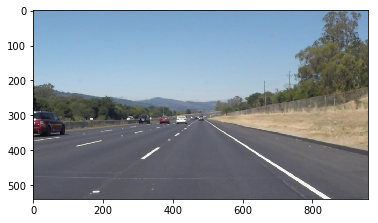

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def Image_preparation(img):
    # added filter to separate yellow line from white road
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_filter = np.array([0,0,0])
    upper_filter = np.array([255,73,255])
    mask = cv2.inRange(hsv,lower_filter, upper_filter)
    filtered_image = cv2.bitwise_and(img,img,mask = mask)
    # thransform the 
    result= cv2.cvtColor(filtered_image, cv2.COLOR_RGB2GRAY)
    return result #filtered_image
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

test_images/solidWhiteCurve.jpg


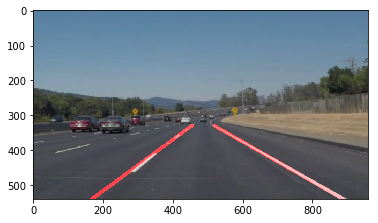

test_images/solidWhiteRight.jpg


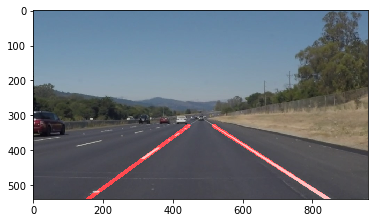

test_images/solidYellowCurve.jpg


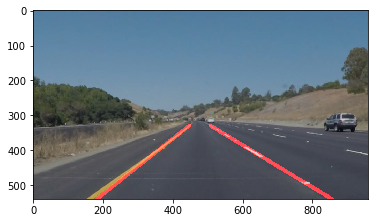

test_images/solidYellowCurve2.jpg


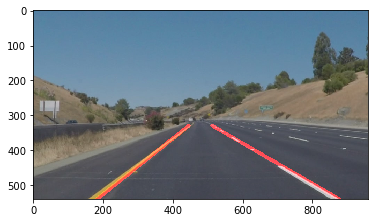

test_images/solidYellowLeft.jpg


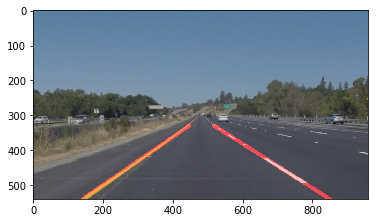

test_images/whiteCarLaneSwitch.jpg


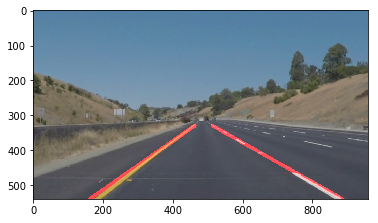

In [8]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# 1 define pipeline parameters
testDirectory='test_images/'
x_v=960/2 # vanishing point x coordinate
y_v=310 # vanishing point y coordinate
y_M=540 # picture height
x_M=960 # picture width
angle_filter=20 #in degree, lines less inclined than this angle are ignored
vertices = np.array([[(0,540),(450,330),(530,330),(960,540)]], dtype=np.int32)
gaussian_smoothing_kernel_size = 5            
canny_low_threshold = 100         
canny_high_threshold = 150       
hough_rho=2 # distance resolution in pixels of the Hough grid
hough_theta=np.pi/180 # angular resolution in radians of the Hough grid
hough_threshold=10     # minimum number of votes (intersections in Hough grid cell)
hough_min_line_len= 30   #minimum number of pixels making up a line
hough_max_line_gap= 20  # maximum gap in pixels between connectable line segments
# color filtering
red_threshold = 10
green_threshold = 10
blue_threshold = 10
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# 2 define usefull functions
def image_resize(img):
    # for the chalenge resize the image tto 960x540
    img_out=cv2.resize(img,(960,540), 0, 0, cv2.INTER_LINEAR) #cv2.INTER_CUBIC a slower option
    return img_out

def image2Road(x,y):
    # transform the Image coordinates x & y into road coordinates zz (forward distance from camera) and xx(side distance from camera)
    # for the distance, we assume that the bottom of the image corespond to a point @ 2m from the camera
    # for the width we assume that the bottom righ corner of the image corespond to a point @ 2m on the camera side
    # y_M=540 & x_M=960 correspond to xx= 2m and zz=2m
    # and for the vanishing point y_v=300 and x_v=430 corespond to zz= infinity and xx=0
    a=2
    b=2
    if y>y_v:
        xx= b*(x-x_v)/(x_M-x_v)*(y_M-y_v)/(y-y_v)
        zz= a*(y_M-y_v)/(y-y_v)
        return xx,zz
    
def road2Image(xx,zz):
    # not used but kept in case :-)
    # transform the road coordinates zz (forward distance from camera) and xx(side distance from camera) into Image coordinates x & y 
    # inverse of the Image2Road function
    a=2
    b=2
    y=int(y_v+a*(y_M-y_v)/zz)
    x=int(x_v+xx/b*(x_M-x_v)*(y-y_v)/(y_M-y_v))
    return x,y
    
def lineParameters(x1,y1,x2,y2):
    # from the extremity points generates the line center point, the line angle and the line lenght
    x3=(x1+x2)/2
    y3=(y1+y2)/2
    lenght=np.sqrt((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1))
    teta=np.arctan2(y2-y1,x2-x1)
    return x3,y3,teta,lenght

def lineAgregate(x_sum,y_sum,angle_sum,lenght_sum):
    # average the sum with respect to the lines lenght
    x=x_sum/lenght_sum
    y=y_sum/lenght_sum
    angle=angle_sum/lenght_sum
    return x,y,angle

def lineStretch(x,y,angle,y_min,y_max):
    # extend a line passing through (x,y) with a given angle  
    # to the intersection with the 2 horizontal lines Y=y_min and y=y_max
    if (np.tan(angle)!=0):
        # non vertical line
        x0=int(x+(y_min-y)/np.tan(angle))
        x1=int(x+(y_max-y)/np.tan(angle))
    else: #
        # vertical line
        x0=x
        x1=x
    return x0,y_min,x1,y_max

def sort_lines(lines):
    '''
    reduces the vertex into 1 right line and 1 left line whenever possible
    the averaging is barycentric with the line lenght as the weight
    '''
    #variables init
    x_right_line_center_sum=0
    y_right_line_center_sum=0
    angle_right_line_sum=0
    right_line_lenght_sum=0
    x_left_line_center_sum=0
    y_left_line_center_sum=0
    angle_left_line_sum=0
    left_line_lenght_sum=0
    new_lines=([[]]) 
    
    for i in range(len(lines)):
        x1=lines[i][0][0]
        y1=lines[i][0][1]
        x2=lines[i][0][2]
        y2=lines[i][0][3]
        # ordering lines
        if (y1>y_v) and (y2>y_v):
            # should always be the case, image area below the vanishing line
            if y1 > y2:
                x1,x2,y1,y2=x2,x1,y2,y1
            # first and second parameter is the line center of gravity
            x_line_center,y_line_center,line_angle,line_lenght = lineParameters(x1,y1,x2,y2)
            # transforming in real coordinates (xx and zz) (projection reversed)
            # for the distance, we assume that y_M=540 corespond to zz=2
            # and y_v=300(vanishing point) corespond to z= infinity
            # for the width, we assume that for x_M=960 (bottom edge of the picture) correspond to xx=2
            xx1,zz1=image2Road(x1,y1)
            xx2,zz2=image2Road(x2,y2)
            # in road coordinates, only the line lenghts are considered and image line lenght are over writen
            xx,zz,angle,line_lenght=lineParameters(xx1,zz1,xx2,zz2)
            # new center point calculation
            # condition de position ajout2e pour yellow line
            # supression of horizontal lines
            if (line_angle > (np.pi*angle_filter/180)) and (line_angle<(np.pi*(180-angle_filter)/180)):
                # the horizontal-ish lines are ignored
                if line_angle>np.pi/2: #x2>x_v and x1>x_v :
                    #print(' a good one right', line_angle*180/np.pi)
                    #print('right line')
                    x_right_line_center_sum += x_line_center*line_lenght
                    y_right_line_center_sum += y_line_center*line_lenght
                    angle_right_line_sum += line_angle*line_lenght
                    right_line_lenght_sum += line_lenght
                else: #elif x2<x_v and x1<x_v:
                    #print(' a good one left', line_angle*180/np.pi)
                    #print('left line')
                    x_left_line_center_sum += x_line_center*line_lenght
                    y_left_line_center_sum += y_line_center*line_lenght
                    angle_left_line_sum += line_angle*line_lenght
                    left_line_lenght_sum += line_lenght
                    
    # agregated lines centerpoint and angle
    # extrapolation of the line to the mask limits
    # intersection with bottom and top limit
    # bottom limit : y= 540  
    y_M=540
    # top limit: y= 330
    y_m=330
    
    if (right_line_lenght_sum !=0):
        # if there is a right line
        x0,y0,teta= lineAgregate(x_right_line_center_sum,y_right_line_center_sum,angle_right_line_sum,right_line_lenght_sum)
        x1,y1,x2,y2=lineStretch(x0,y0,teta,y_M,y_m)
        # print(x1,y1,x2,y2)
        # back to image space
        # adding the line
        new_lines.append([[x1,y1,x2,y2]])       
        
    if (left_line_lenght_sum !=0):
        # if there is a left line
        x0,y0,teta= lineAgregate(x_left_line_center_sum,y_left_line_center_sum,angle_left_line_sum,left_line_lenght_sum)
        x1,y1,x2,y2=lineStretch(x0,y0,teta,y_M,y_m)
        # back to image space
        # adding the line
        new_lines.append([[x1,y1,x2,y2]]) 
    
    if (right_line_lenght_sum ==0)and (left_line_lenght_sum ==0):
        # neither right or left line
        new_lines=None
        
    #print(new_lines)
    return new_lines

# 3 define pipeline sequence
def pipeline(image):
    # resize image
    image_resized=image_resize(image)
    # pre process the image
    gray= Image_preparation(image_resized)
    # apply Gaussian smoothing
    blur_gray= gaussian_blur(gray,gaussian_smoothing_kernel_size)
    # extract edges
    edges = canny(blur_gray, canny_low_threshold, canny_high_threshold)
    # define the image masks, 
    # note: the masks are inserted before the hough to reduce computation time
    # apply mask
    edge_focus=region_of_interest(edges, vertices)
    # get lines from right edges area
    lines = cv2.HoughLinesP(edge_focus, hough_rho, hough_theta, hough_threshold, np.array([]), hough_min_line_len, hough_max_line_gap)
    # simplify the lines
    simplified_lines=sort_lines(lines)
    # draw black image with lines
    black_img_with_lines = np.zeros((image_resized.shape[0], image_resized.shape[1], 3), dtype=np.uint8)
    # add lines
    # lines are scaled to image size
    #draw_lines(black_img_with_lines, simplified_lines,[255,0,0],10)
    draw_lines(black_img_with_lines,simplified_lines,[255,0,0],10)
    # merge line image with original image
    image_with_both_lines=weighted_img(black_img_with_lines, image_resized)
    #
    return image_with_both_lines

# 4 loop pipeline through all test pictures
plt.ion()   # note: to unfreeze plt.show() 
for i in range(len(os.listdir('test_images/'))):
    imgName= 'test_images/' + os.listdir('test_images/')[i]
    image= mpimg.imread(imgName)
    image_with_lines=pipeline(image)
    print(imgName)
    #images saved in new directory
    #mpimg.imsave('test_images_2/'+os.listdir(testDirectory)[i],image_out)
    #display result
    plt.imshow(image_with_lines)                                                                                                                                                                                       
    plt.show()
    next


### Test on Videos You know what's cooler than drawing lanes over images? Drawing lanes over video! 
We can test our solution on two provided videos: solidWhiteRight.mp4 solidYellowLeft.mp4 
    Note: 
    if you get an import error when you run the next cell, 
        try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? 
        Try relaunching Jupyter Notebook from the terminal prompt. 
        Also, check out this forum post for more troubleshooting tips. 
    If you get an error that looks like this: NeedDownloadError: Need ffmpeg exe. 
            You can download it by calling: imageio.plugins.ffmpeg.download() 
    Follow the instructions in the error message and check out this forum post for more troubleshooting tips across operating systems.

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

NeedDownloadError: Need ffmpeg exe. You can download it by calling:
  imageio.plugins.ffmpeg.download()

In [7]:
def process_image(image):
    image_resized=image_resize(image)
    # pre process the image
    gray= Image_preparation(image_resized)
    # apply Gaussian smoothing
    blur_gray= gaussian_blur(gray,gaussian_smoothing_kernel_size)
    # extract edges
    edges = canny(blur_gray, canny_low_threshold, canny_high_threshold)
    # define the image masks, 
    # note: the masks are inserted before the hough to reduce computation time
    # apply mask
    edge_focus=region_of_interest(edges, vertices)
    # get lines from right edges area
    lines = cv2.HoughLinesP(edge_focus, hough_rho, hough_theta, hough_threshold, np.array([]), hough_min_line_len, hough_max_line_gap)
    # simplify the lines
    simplified_lines=sort_lines(lines)
    # draw black image with lines
    black_img_with_lines = np.zeros((image_resized.shape[0], image_resized.shape[1], 3), dtype=np.uint8)
    # add lines
    # lines are scaled to image size
    #draw_lines(black_img_with_lines, simplified_lines,[255,0,0],10)
    # *******
    draw_lines(black_img_with_lines,simplified_lines,[255,0,0],10)
    # merge line image with original image
    #plt.imshow(black_img_with_lines)                                                                                                                                                                                       
    #plt.show()
    image_with_both_lines=weighted_img(black_img_with_lines, image_resized)
    #
    return image_with_both_lines

#### Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:04<00:00, 44.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 5.03 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:12<00:00, 57.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 12.4 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Reflections:

the pipeline is quite straight forward

1- the image is pre-processed to help edges detection
    - image is resized if needed
    - HSV filtering
    - gray transformation
    - gaussian filter to remove small perturbations
    
2- The edges are computed

3- A mask is applied to limit further treatment to the area of interest

4 - The lines are extrapoleted from the edges

5- The lines are filtered and cleaned
    - the extermity points are ordered in y growing order(to get the angles right)
    - lines too close to the horizontal are removed
    - the lines centers, angles to horizontal and real lenght (with reference to the lenght on the road) are computed
    
6- The lines are agregated into a right line and a left line
    - depending of the angle value the lines are sorted in a right and in a left set
    - the lines centers and angles are agregated as a barycenter using the lines estimated real lenght (on the road) as weight
    
7- The lines are extended up to 2 virtual horizon tal lines
8- The 2 lines are drawn on a black image
9- The black image is merged on top of the original (resized) image

## How to make the code more robust:

1- Image size:
    - Make a check of the image size and resize the image to 900x540 in this case

2- shaking lines:
    - To avoid having the top of the lines moving jumping right and left betwwen frames, I have moved to road coordinates,the idea is that due to the perspective effect, lines far away appear shorter in the image and got less weight in the merging process.by moving to road coordinate this effect is removed

3- horizontal lines:
    - Adding a filter to ignore horizontal-ish lines, I have selected to ignore line which angle is < 20 deg fron the horizontal

4- Additional filtering:
    - In the chalenge, the yellow line is difficult to distinguish from the 'concrete' backgroung, to remove this problem, I have moved to HSV mode and filtered through a saturation level (after playing with the options), it seems to sort most of it

5- camera orientation:
    - It looks like the vanishing point has moved in the chalenge video from the previous video, this may explain why the lines are not tracking perfectly, an idea may be to remove completly this vertex point from the calculation (of the line lenght) to make the code more robust

6- Linking the frames:
    - In order to avoid the jump of the lines from one frame to another, it may be worth trying to damp this motion by averaging (or ponderating) the location of the line extremity points over a few past frames.

7- mask size:
    - In the "chalenge" video, since the program sort lines by the angle between right and left, when the road turn, sone far away lines are put in the wrong category this lead to poor resuls, one easy fix is to reduce the size of the mask.

8- Line upgrade:
    - Aproximating a curve with a line will never be great, therefore moving to a polyline or a spline in stead may be an option.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:06<00:00, 40.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 6.69 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))